In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

In [ ]:
# with open('crypto_list.pkl', 'wb') as fp:
#     pickle.dump(crypto_list, fp)

In [197]:
import networkx as nx
import math

from itertools import combinations
from operator import itemgetter
from timeit import default_timer
from random import shuffle

EPS = 1e-6
R0 = 0.0192

r0 = np.log(np.exp(R0)**(1/365))
r0

5.260273972608513e-05

In [198]:
import neal
import dimod

In [199]:
from WMIS import *

In [200]:
class Market(object):
    
    def __init__(self, tickers, start_date= '2010-01-01', end_date = '2019-01-01'):
        
        print(start_date, end_date)
        self.data = yf.download(tickers, start = start_date, end = end_date ).fillna(method = 'bfill')
        tickers = np.array(tickers)
        
        # отбираем только фонды с положительным доходом
        change_data = self.data.Close/self.data.Close.shift(periods=1)
        market_profit = change_data.mean()
        print(market_profit)
        self.change_data = change_data.T[market_profit > (1+EPS)].T
        
        # Рассчитываем доходность и риск
        self.N = len(self.change_data.T)
        self.tickers = list(tickers[market_profit > (1+EPS)])
        self.market_profit = np.log(self.change_data.mean())
        self.market_risk = self.change_data.cov()
        
        self.v_list = (self.market_profit) - 0.2*np.diagonal(self.market_risk)
#         v_list = v_list - min(v_list)
#         self.v_list = v_list/np.sum(v_list)
        self.e_matrix = self.change_data.corr()
    
        
        
        self.G = None
        self.vert_weights = None
        self.wmis_mask = None
        self.wmis_G = None
        self.J = None
        self.h = None
        self.g = None
        
        self.B = None
        
    def build_Ising_hamiltonian(self, theta, weighted = False, drop_num = 3 ):
        
        self.B = 1
        B = self.B

        # portfolio.gamma = 1

#         theta = np.zeros(3)

#         theta[0] = 1
#         theta[1] = 2 #portfolio.gamma
#         theta[2] = 0.01 #portfolio.rho

        # equal_weighted
        if weighted == False:
            A_list = np.array(([1] * self.N))

        # Sharp_weighted
        elif weighted == True:
            A_list = (self.market_profit/np.diagonal(self.market_risk)).values

        A_list = A_list/(np.sum(A_list) - drop_num)
        A_matrix = np.kron(np.reshape(A_list, [len(A_list),1]), A_list)

        Cov = self.market_risk.values
        P = self.market_profit.values

        J_matrix = -1/4*(theta[1]*self.market_risk.values + theta[2]*A_matrix)
        h_list = -1/2*(theta[1]*np.diagonal(self.market_risk.values) + theta[2]*np.diagonal(A_matrix) - theta[0]*P - 2*B*theta[2]*A_list)    
        g = theta[2]*B**2
        
        



        J = {}

        for i in range(len(J_matrix)):
            for j in range(len(J_matrix)):
                J.update({(i,j): J_matrix[i][j]})

        h = dict(zip(list(range(len(h_list))), list(h_list)))
        
        self.J = J
        self.h = h
        self.g = g
        
    def build_market_graph(self, edge = 0.25):
        
        edge = np.log(np.exp(edge)**(1/365))
        
        ind_vert_list = []
        ind_vert_weight = []
        
        clist = []
        elist = []
        v_list = []
        for c1, p  in zip(self.change_data.cov().to_dict().keys(), self.v_list):
            clist.append(c1)

            i = 0
            for c2, corr in self.change_data.cov().to_dict()[c1].items():
                if ((corr > edge) & (c1 != c2)):
                    i += 1
                if ((clist.count(c2)==0) & (corr > edge) & (c1 != c2)):
                    elist.append((c1, c2, corr))
                    
            if i == 0:
                ind_vert_list.append(c1)
                ind_vert_weight.append(p)
            else:
                v_list.append(p)
                

        G=nx.Graph()
        G.add_weighted_edges_from(elist)
        G.add_nodes_from(ind_vert_list)
        v_list.extend(ind_vert_weight)
        self.G = G
        self.vert_weights = dict(zip(G.nodes(), v_list))
        
        
    def build_mwis(self):
        
        mwis_set, mwis_weight = exact_MWIS(self.G, self.vert_weights, 0)
        
        mask = []
        for t in set(self.tickers):
            mask.append(int(t in mwis_set))
        mask = np.array(mask)
        self.wmis_mask = mask
        self.wmis_G = nx.subgraph(self.G, mwis_set)
        
    def draw_market(self):
        nx.draw_networkx(self.G)
        
    def draw_wmis(self):
        nx.draw_networkx(self.wmis_G)
        
    def get_market_profit(self):
        return self.market_profit
    
    def get_market_risk(self):
        return self.market_risk
    
    def get_data(self):
        return self.data
    
    def get_change_data(self):
        return self.change_data
    

    


class Portfolio(Market):
    
    def __init__(self, market):
        
        self.tickers = market.tickers
        self.data = market.data
        self.N = market.N
        
        self.change_data = market.change_data
        self.market_profit = market.market_profit
        self.market_risk = market.market_risk
        self.v_list = market.v_list
        self.e_matrix = market.e_matrix
        
        self.G = market.G
        self.vert_weights = market.vert_weights
        self.wmis_mask = market.wmis_mask
        self.wmis_G = market.wmis_G
        
        self.J = market.J
        self.h = market.h
        self.g = market.g
        
        self.B = market.B

        self.weights = None
        self.profit = None
        self.risk = None
        self.Sharp_koef = None
        self.mask = None
        self.rho = 1
        self.gamma = 0.1
        self.cost = 2000
        
#         self.mask = None
        
        
    def build_portfolio(self, weights = None):
        if weights == None:
            weights = np.abs(np.random.randn(self.N))
        else:
            weights = np.array(weights)
        self.weights = weights / np.sum(weights)
        self.profit = np.dot(self.market_profit,self.weights)
        self.risk = np.dot(np.dot(self.weights,self.market_risk.values),self.weights)
        self.Sharp_koef = (np.log(np.exp(self.profit)**365) - R0)/np.log(np.exp(self.risk)**365)
        self.cost = -self.profit + self.gamma/2*self.risk + self.rho*np.sum(self.weights - 1)**2
        
        
#         print(self.weights, self.risk, self.profit, self.Sharp_koef)
        
    def get_weights(self):
        return self.weights
    
    def get_profit(self, period = 1):
        if period == 1:
            return self.profit
        return np.log(np.exp(self.profit)**period)
    
    def get_risk(self, period = 1):
        if period == 1:
            return self.risk
        return np.log(np.exp(self.risk)**period)
    
    def get_Sharp(self):
        return self.Sharp_koef
    
    def get_cost(self):
        return self.cost
    
    def build_binary_portfolio(self, weighted = True, alpha = 0 , mask = None):
        
        
        if mask == None:
            mask = np.random.randn(self.N)
            mask[mask>=0.5] = 1
            mask[mask<0.5] = 0
        else:
            mask = np.array(mask)
        
        if weighted == True:
            weights = mask * (self.market_profit*np.diag(self.market_risk.values) + alpha)
        else:
            weights = mask
            
        self.weights = weights / np.sum(weights)
        
        
        
        self.profit = np.dot(self.market_profit,self.weights)
        self.risk = np.dot(np.dot(self.weights,self.market_risk.values),self.weights)
        self.Sharp_koef = (np.log(np.exp(self.profit)**365) - R0)/np.log(np.exp(self.risk)**365)
        self.cost = -self.profit + self.gamma/2*self.risk + self.rho*(np.sum(self.weights) - 1)**2
        
#         print(mask, self.weights, self.risk, self.profit, self.Sharp_koef)
        
        
    

        
        
    
    
def get_time(function, params = None):
    start_time = time.time()
    
    if params != None:
        data_out = function(**params)
    else:
        data_out = function()
        
    dt = (time.time() - start_time)
    print("--- %s seconds ---" % (dt))
    return data_out, time
    

        

In [201]:
# np.min(market.v_list), np.mean(market.v_list)

In [202]:
ETF_list = 'IEFA	IEMG	BNDX	IXUS	QUAL	ARKK	ESGU	DGRO	VTIP	VLUE	GOVT	IUSB	MTUM	VTEB	GSLC	NOBL	ARKG	FPE	FNDX	SRLN	LMBS	ESGE	MOAT	FNDF	HYLB	ESGD	DGRW	FTEC	INDA	PDBC	ISTB	ARKW	ICSH	KWEB	RDVY	IEUR	SHYG	ANGL	NEAR	SPYD	SJNK	FNDE	FNDA	CIBR	XLRE	FTSM	XSOE	BOND	QYLD	SPSM	XT	VIGI	IAGG	IQLT	REET	JETS	FALN	TOTL	VWOB	GSIE	SPHD	FHLC	HEFA	NFRA	FV	VNLA	VYMI	FNDC	ARKQ	COMT	BOTZ	FTSL	SLQD	BSCM	FMB	HACK	JHMM	HYLS	ASHR	BSCN	EMLP	FBND	RODM	PTLC	VRP	GBIL	FREL	ROBO	FNCL	ICVT	FTGC	TDIV	BSCL	QDF	IBDO	BSCO	FDIS	PSC	JPHY	IBDN	URTH	XMLV	IBDP	IBDM	FINX	HYEM	GEM	FPXI	IPAY	MJ	EMQQ	QLTA	SPYX	LRGF	SDOG	IBDQ	LDUR	FUTY	XSLV	IPAC	IVLU	FTXR	FDVV	USFR	NULV	AGGY	PICK	IHDG	FLCO	BSCP	REGL	PFXF	SMLF	IBUY	NUSC	QUS	CFO	CDC	CXSE	FCOM	IGHG	MLPA	INTF	BSJM	CRBN	JPIN	KSA	GTO	TIPX	SMMV	FIDU	NULG	IMTM	EEMA	FSTA	LABU	SMDV	FENY	QEFA	SILJ	HDEF	PTNQ	DVYE	CMBS	IGBH	LVHD	IBDR	JHML	KBA	COWZ	HEZU	OUSA	RDIV	EMGF	IDLV	CFA	JPUS	GUSH	ONEY	DIV	TLTD	MLPX	BSJN	EQAL	SIZE	CNYA	DBEU	DIVO	IQDF	LGLV	LQDH	ONEV	BSCQ	CATH	JNUG	SDG	SPGM	BSJL	RING	FDLO	FMAT	HEWJ	JHMD	IPO	PRNT	KRMA	SRET	OUNZ	FDRR	HAUZ	GNMA	FM	DPST	MDIV	CEMB	VIDI	TPYP	XYLD	FTSD	SNSR	NANR	EMHY	VRIG	SPHY	YYY	BIZD	FVAL	QDEF	DWAS	CAPE	PTMC	VUSE	QQQE	VBND	SHYD	ROUS	ULST	GQRE	NAIL	FTLS	RAVI	IBMK	FNDB	NUMG	BSJO	NUAG	XITK	EELV	WDIV	HFXI	ONEO	TLTE	SMIN	TFLO	SKOR	FCOR	GAL	IBMJ	IQDG	MEAR	FLTB	SYLD	FEMB	IFV	FLGE	SHE	AMZA	FCVT	SLVO	FQAL	ADME	SLVP	CSB	NUMV	EFAX	IGRO	FFTY	IYLD	STOT	PGHY	JPME	YLD	AIRR	PHDG	SPFF	SGDM	CDL	GVIP	EPRF	MILN	FTXO	REML	FVC	SMLV	QVAL	AGZD	VLU	SBIO	DEUS	ISCF	GHYG	ITEQ	KLDW	DGRS	HEEM	TTAC	JSMD	MLPB	IDOG	ESGG	ATMP	WFHY	CWEB	ETHO	ESG	RFDI	EEMX	EDEN	DJD	FBGX	JPSE	HYZD	DDWM	FEMS	BYLD	JPEM	BRZU	OUSM	RVNU	SPVU	BFOR	BTEC	EFAD	JSML	USDU	QLC	IVAL	GCOW	RLY	ACWF	IMTB	RIGS	FLLV	CHAD	RNRG	DBAW	RFDA	HYHG	EWUS	TOLZ	HYGH	GVAL	HAWX	HUSV	IPKW	FDMO	FIBR	BNDC	SGDJ	CIL	LOWC	CBON	IHY	FSZ	CHAU	INKM	FAAR	FGM	SPDN	MBSD	GENY	TTT	GAMR	GLDI	EMTL	RFCI	MINC	HSCZ	FKU	DGRE	MMTM	HDMV	QMOM	QAT	EWRE	SPMO	ISRA	VEGI	RFEU	ACSI	QEMM	NFTY	FILL	LVHI	AMUB	PSET	IMOM	GURU	EYLD	FTXL	IQDE	NURE	IBDD	HYXU	DEEF	JDST	IQDY	MOTI	PY	CSF	JHMT	ENFR	WBIY	RFFC	OILK	AGNG	PUTW	HIPS	HEWG	BUFF	DRIP	SDEM	FMF	FDIV	XWEB	EURL	LABD	LKOR	EUDG	IVES	PTEU	BDCZ	EUSC	JHMH	QWLD	GAA	UCIB	WBII	EMCB	XRLV	WBIF	MRGR	WFIG	RFEM	FTXN	DEEP	FTHI	WBIG	DAX	ENOR	WBIL	DDLS	CNXT	CNCR	FID	DVYA	NGE	KORU	HOLD	EWGS	CIZ	ROAM	OEUR	SNLN	BFIT	GYLD	TCTL	JHMF	BBC	DDIV	XCEM	FCEF	UTES	FYLD	RINF	SFIG	ASHS	SPUU	ICOL	USLB	ALTY	DXGE	ALFA	FLRT	OLD	IBCE	EFNL	ASET	DXJS	CWS	CN	FLQD	SPXE	HTUS	IPOS	FEUZ	PAK	CSA	SMCP	FIHD	HDAW	BBP	ISZE	JHMC	ROSC	EDOG	JPN	FLQE	UAE	KALL	FTXH	EINC	MLPO	PEX	JHMS	VAMO	CID	QDYN	XSHD	EMDV	GSEU	EMFM	NFLT	SFHY	CRAK	JHMA	VEGA	FTXD	MCEF	IDHD	JHMU	QMN	JHME	FLQH	JHMI	FLQG	HEWC	DBEZ	QLS	PGAL	GSJY	ASHX	QED	KFYP	RFUN	FIEE	FRAK	EFAS	EUDV	INFR	IMLP	DWPP	ALTS	FTLB	FDTS	RFAP	TAGS	SPXT	HEWU	AFTY	SPXN	IDLB	EMSH	EMBH	IDMO	EEMO	FAIL	FUT	BLHY	FTXG	ESGN	ESGS	CROC	SPXV	WIL	DWAT	DIVA	HJPX	EURZ	RODI	EUFX'.split('	')
crypto_list = 'LINK-USD	DERO-USD	ENJ-USD	DOGE-USD	THETA-USD	DAG-USD	MANA-USD	KNC-USD	STORJ-USD	ADA-USD	XDN-USD	ZRX-USD	CTXC-USD	SNX-USD	LCC-USD	SBD-USD	BNB-USD	POLIS-USD	XMY-USD	BAT-USD	MLN-USD	ADX-USD	ZEL-USD	RVN-USD	PAC-USD	TRTL-USD	QNT-USD	DGB-USD	NAV-USD	LOKI-USD	HOT1-USD	ZEN-USD	QTUM-USD	ARDR-USD	MKR-USD	RLC-USD	WAVES-USD	SC-USD	DCR-USD	SNT-USD	VTHO-USD	LTC-USD	REP-USD	VERI-USD	XTZ-USD	AVA-USD	XHV-USD	ETC-USD	SYS-USD	HC-USD	GNO-USD	BTC-USD	VET-USD	WICC-USD	FUN-USD	NANO-USD	TOMO-USD	XSN-USD	IOST-USD	ZIL-USD	ETH-USD	CVC-USD	PART-USD	HTML-USD	IOTX-USD	ANT-USD	DNT-USD	OMG-USD	GCC1-USD	VIA-USD	WAXP-USD	DGD-USD	STEEM-USD	XVG-USD	NLG-USD	XRP-USD	NEBL-USD	ETN-USD	NIM-USD	APL-USD	WABI-USD	FIL-USD	LSK-USD	TRX-USD	LRC-USD	MED-USD	NXS-USD	RDD-USD	XEM-USD	GRS-USD	BTG-USD	DCN-USD	MTL-USD	MIOTA-USD	VIN-USD	EOS-USD	GRC-USD	NEO-USD	AION-USD	MAN-USD	QRK-USD	TUSD-USD	DIME-USD	ICX-USD	WTC-USD	KMD-USD	UBQ-USD	ARK-USD	BLK-USD	BCD-USD	MONA-USD	BNT-USD	PAY-USD	TRUE-USD	BLOCK-USD	EMC2-USD	WGR-USD	NKN-USD	FRST-USD	GAS-USD	XMR-USD	CMT1-USD	SKY-USD	USDT-USD	ZEC-USD	PIVX-USD	DASH-USD	QRL-USD	XLM-USD	XCP-USD	MRX-USD	XST-USD	WAN-USD	BTM-USD	GO-USD	VTC-USD	FTC-USD	FAIR-USD	MCO-USD	FLO-USD	AEON-USD	AMB-USD	XWC-USD	NULS-USD	BCH-USD	LBC-USD	XMC-USD	ELA-USD	NMC-USD	GXC-USD	SFT-USD	BTS-USD	DYN-USD	USNBT-USD	IOC-USD	XBY-USD	INSTAR-USD	ONT-USD	NRG-USD	COLX-USD	YOYOW-USD	AE-USD	CURE-USD	SNGLS-USD	POA-USD	NLC2-USD	INT-USD	TUBE-USD	PPT-USD	QASH-USD	SALT-USD	NAS-USD	ACT-USD	BCN-USD	SMART-USD	ADK-USD	PPC-USD	MGO-USD	DMD-USD	MAID-USD	VEX-USD	PI-USD	CRW-USD	GBYTE-USD	PHR-USD	NXT-USD	NIX-USD	BCA-USD	EDG-USD	VITE-USD	PZM-USD	WINGS-USD	FCT-USD	ETP-USD	KIN-USD	ATB-USD	XAS-USD	PAI-USD	GAME-USD	HPB-USD	XUC-USD	BTX-USD	BHP-USD	FSN-USD	SUB-USD'.split('	')

In [203]:
# ticker_list = ['SPY','EEM','EMJ','FXI','IWM','GDX','QQQ',
#                'VWO', 'ADRU', 'EFA', 'RSX', 'VGK', 'JNK',
#                'FGD', 'IOO', 'VT', 'CWI', 'GWX','KOL', 'FEZ']

sample_num = 15
ETF_num = int(sample_num*len(ETF_list)/(len(ETF_list) + len(crypto_list)))
crypto_num = int(sample_num*len(crypto_list)/(len(ETF_list) + len(crypto_list)))
sample_ticker = ETF_list[:ETF_num] + crypto_list[:crypto_num]
print(sample_ticker, ETF_num, crypto_num )

market, t = get_time(Market, params = {'tickers' : sample_ticker, 'start_date' : '2018-01-01', 'end_date' : '2021-01-01'})
portfolio, t = get_time(Portfolio, {'market' : market})

['IEFA', 'IEMG', 'BNDX', 'IXUS', 'QUAL', 'ARKK', 'ESGU', 'DGRO', 'VTIP', 'VLUE', 'GOVT', 'LINK-USD', 'DERO-USD', 'ENJ-USD'] 11 3
2018-01-01 2021-01-01
[*********************100%***********************]  14 of 14 completed
ARKK        1.001254
BNDX        1.000071
DERO-USD    1.001811
DGRO        1.000304
ENJ-USD     1.003107
ESGU        1.000428
GOVT        1.000081
IEFA        1.000095
IEMG        1.000144
IXUS        1.000107
LINK-USD    1.005341
QUAL        1.000377
VLUE        1.000118
VTIP        1.000044
dtype: float64
--- 2.747102975845337 seconds ---
--- 2.002716064453125e-05 seconds ---


In [204]:
    
def build_ising_ham(portfolio, theta, return_all = True, market_num = (portfolio.N - 3)):
    B = 1

    # portfolio.gamma = 1

    #         theta = np.zeros(3)

    #         theta[0] = 1
    #         theta[1] = 2 #portfolio.gamma
    #         theta[2] = 0.01 #portfolio.rho

    # equal_weighted
    if weighted == False:
        A_list = np.array(([1] * portfolio.N))

    # Sharp_weighted
    elif weighted == True:
        A_list = (portfolio.market_profit/np.diagonal(portfolio.market_risk)).values
        

    A_list = A_list/market_num
    A_matrix = np.kron(np.reshape(A_list, [len(A_list),1]), A_list)
    

    Cov = portfolio.market_risk.values
    P = portfolio.market_profit.values

    J_matrix = 1/4*(theta[1]*portfolio.market_risk.values + theta[2]*A_matrix)
    h_list = 1/2*(theta[1]*np.sum(Cov, axis = 0) + theta[2]*np.sum(A_matrix, axis = 0) - theta[0]*P - 2*B*theta[2]*A_list)  
    g =  - theta[0]/2*np.sum(P) + theta[1]/4*np.sum(Cov) + theta[2]/4*(np.sum(A_matrix) - 4*B*np.sum(A_list) + 4*B**2)





    J = {}

    for i in range(len(J_matrix)):
        for j in range(len(J_matrix)):
            J.update({(i,j): J_matrix[i][j]})

    h = dict(zip(list(range(len(h_list))), list(h_list)))
    
    if return_all == True:
        return J, h, J_matrix, h_list, A_matrix, A_list, B
    
    return J, h

In [233]:
def test_effective_boundary(portfolio, sampler, weighted = False, theta = [1, 3, 0.01], market_num = (portfolio.N - 2)):

    risk_list = []
    profit_list = []
    sharp_list = []
    gamma_list1 = []
    gamma_list2 = []
    
#     portfolio.B = 0.2


    for k in range(4):
        for i in range(1,21):
            for j in range(1,21):

                if k == 0:
                    theta[0] = 1
                    theta[1] = 1/i
                    theta[2] = 1/j*10e-3
                elif k == 1:
                    theta[0] = 1
                    theta[1] = 1*i
                    theta[2] = 1*j*10e-3
                elif k == 2:
                    theta[0] = 1
                    theta[1] = 1/i
                    theta[2] = 1*j*10e-3
                    
                elif k == 3:
                    theta[0] = 1
                    theta[1] = 1*i
                    theta[2] = 1/j*10e-3
                    

                J, h, J_matrix, h_list, A_matrix, A_list, B = build_ising_ham(portfolio, theta, return_all = True, market_num = market_num)
                #         print(portfolio.J, portfolio.h)
                sampleset = sampler.sample_ising(h, J)
                mask = np.array(list(sampleset.first.sample.values()))

        #         mask[mask == 1] = 0
                mask[mask == -1] = 0

                print(mask, theta[1])
                print(np.dot(mask, np.dot(J_matrix,mask)) , np.dot(mask, h_list), np.dot(mask,A_list),B)
                print(theta[0]*np.dot(mask, portfolio.market_profit.values),
                      theta[1]*np.dot(mask, np.dot(portfolio.market_risk.values ,mask)), 
                      theta[2]*(np.dot(mask,A_list) - B)**2)


                portfolio.build_binary_portfolio(weighted = False, alpha = 0 , mask = list(mask))

        #         print(portfolio.get_Sharp())

                risk_list.append(portfolio.get_risk(period = 365)*100)
                profit_list.append(portfolio.get_profit(period = 365)*100)
                gamma_list1.append(theta[1])
                gamma_list2.append(theta[2])
                sharp_list.append(portfolio.get_Sharp())

    return gamma_list1, gamma_list2, risk_list, profit_list, sharp_list

In [234]:
sampler =  neal.SimulatedAnnealingSampler() # dimod.ExactSolver() #
weighted = False
theta_init = [1,1,1]

r = test_effective_boundary(portfolio, sampler, weighted = False, theta = [1, 3, 0.01], market_num = 12)

df = pd.DataFrame(np.array(r).T, columns = ['gamma', 'risk','return','sharp'])
r = np.array(r)



[1 1 0 1 0 1 1 0 0 0 0 1 0 1] 1.0
0.0015280210483419015 -0.00037411291067998326 0.5833333333333333 1
0.002558755083265111 0.002709306415589828 0.0017361111111111117
[1 1 0 0 0 1 1 0 0 0 0 1 0 1] 1.0
0.0007296474845427538 0.00043229756865200867 0.49999999999999994 1
0.0022549920329943155 0.001668589938171015 0.00125
[1 1 0 0 0 1 1 0 0 0 0 0 0 1] 1.0
0.0003688274272294474 0.00035024406503788105 0.41666666666666663 1
0.001878200590102205 0.0008966060052140858 0.0011342592592592593
[1 1 0 0 0 1 1 0 0 0 0 0 0 1] 1.0
0.00033265844574796593 0.0004949199909638066 0.41666666666666663 1
0.001878200590102205 0.0008966060052140858 0.0008506944444444446
[1 1 0 0 0 0 1 0 0 0 0 1 0 1] 1.0
0.0003051092957022778 0.0005963756842386565 0.41666666666666663 1
0.001826804164347789 0.000873214960586889 0.0006805555555555557
[1 1 0 0 0 1 1 0 0 0 0 0 0 1] 1.0
0.00029648946426648446 0.0006395959168897324 0.41666666666666663 1
0.001878200590102205 0.0008966060052140858 0.0005671296296296297
[1 1 0 0 0 1 1 0 0 0 

[1 1 0 1 1 1 1 0 0 0 1 1 0 1] 0.2
0.0012859752926709287 -0.0026333636984729432 0.75 1
0.010988073447799668 0.004831401170683716 3.472222222222222e-05
[1 1 0 1 1 1 1 0 0 0 1 1 0 1] 0.2
0.0012818634505656658 -0.002624226271572358 0.75 1
0.010988073447799668 0.004831401170683716 3.289473684210526e-05
[1 1 0 1 1 1 1 0 0 0 1 1 0 1] 0.2
0.001278162792670929 -0.0026160025873618316 0.75 1
0.010988073447799668 0.004831401170683716 3.125e-05
[1 1 1 1 1 1 1 0 0 1 1 1 0 1] 0.16666666666666666
0.0036548163477392705 -0.006898508185605299 0.9166666666666667 1
0.012904154649997121 0.0062164876131793065 6.944444444444432e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.16666666666666666
0.002347256656689432 -0.004873031600496111 0.8333333333333334 1
0.012797347307144968 0.005916804404535504 0.00013888888888888883
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.16666666666666666
0.0020579048048375796 -0.004294327896792407 0.8333333333333334 1
0.012797347307144968 0.005916804404535504 9.259259259259255e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0

0.0013264147147392961 -0.004386386558209649 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 3.472222222222221e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125
0.0013023020604183084 -0.004338161249567674 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 3.0864197530864185e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125
0.0012830119369615183 -0.0042995810026540925 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 2.7777777777777766e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125
0.0012672291086786899 -0.004268015346088437 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 2.5252525252525242e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125
0.001254076751776333 -0.004241710632283723 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 2.3148148148148137e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125
0.0012429478343974158 -0.0042194527975258885 0.8333333333333334 1
0.012797347307144968 0.0044376033034016285 2.136752136752136e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.125

[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.1
0.0009839712779642765 -0.004634522989627895 0.8333333333333334 1
0.012797347307144968 0.003550082642721303 1.5432098765432092e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.1
0.0009788949296861736 -0.004624370293071689 0.8333333333333334 1
0.012797347307144968 0.003550082642721303 1.4619883040935666e-05
[1 1 1 1 1 1 1 0 0 0 1 1 0 1] 0.1
0.0009743262162358813 -0.004615232866171105 0.8333333333333334 1
0.012797347307144968 0.003550082642721303 1.3888888888888883e-05
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.09090909090909091
0.002953517803631098 -0.008443634974574296 0.9166666666666667 1
0.012941793899468758 0.0034112934367466164 6.944444444444432e-05
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.09090909090909091
0.0019031705814088766 -0.006533912752352075 0.9166666666666667 1
0.012941793899468758 0.0034112934367466164 3.472222222222216e-05
[1 1 1 1 1 1 1 0 0 1 1 1 0 1] 0.09090909090909091
0.0015479343378241141 -0.005885399881962506 0.9166666666666667 1
0.012904154649997121 0.00339081142

[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.000955030259292791 -0.005332681926118393 0.9166666666666667 1
0.012941793899468758 0.0028864790618625216 7.716049382716036e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.0009316892099100748 -0.005290243654513454 0.9166666666666667 1
0.012941793899468758 0.0028864790618625216 6.944444444444432e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.0009125919876878527 -0.005255521432291233 0.9166666666666667 1
0.012941793899468758 0.0028864790618625216 6.313131313131302e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.0008966776358360008 -0.0052265862471060475 0.9166666666666667 1
0.012941793899468758 0.0028864790618625216 5.787037037037027e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.0008832116458075106 -0.005202102628872429 0.9166666666666667 1
0.012941793899468758 0.0028864790618625216 5.341880341880333e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.07692307692307693
0.0008716693686402336 -0.005181116670386471 0.9166

0.012941793899468758 0.0025016151869475187 4.084967320261431e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.06666666666666667
0.0007421090436504599 -0.005328836933382418 0.9166666666666667 1
0.012941793899468758 0.0025016151869475187 3.858024691358018e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.06666666666666667
0.0007359666622339557 -0.005317668967170591 0.9166666666666667 1
0.012941793899468758 0.0025016151869475187 3.6549707602339115e-06
[1 1 1 1 1 1 1 0 1 0 1 1 0 1] 0.06666666666666667
0.000730438518959102 -0.005307617797579949 0.9166666666666667 1
0.012941793899468758 0.0025016151869475187 3.472222222222216e-06
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.0625
0.003118439628384656 -0.009379633966980177 1.0 1
0.013048601242320912 0.002473758513538624 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.0625
0.0018684396283846557 -0.007296300633646844 1.0 1
0.013048601242320912 0.002473758513538624 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.0625
0.0014517729617179891 -0.006601856189202399 1.0 1
0.013048601242320912 0.002473758513538624 0

[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.05
0.0006418105262371366 -0.005720332003698585 1.0 1
0.013048601242320912 0.001979006810830899 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.05
0.0006336405915966137 -0.005706715445964382 1.0 1
0.013048601242320912 0.001979006810830899 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.05
0.0006263306500761458 -0.005694532210096934 1.0 1
0.013048601242320912 0.001979006810830899 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.05
0.0006197517027077247 -0.005683567297816231 1.0 1
0.013048601242320912 0.001979006810830899 0.0
[1 1 0 1 0 1 1 0 0 0 0 1 0 1] 1
0.0015280210483419015 -0.00037411291067998326 0.5833333333333333 1
0.002558755083265111 0.002709306415589828 0.0017361111111111117
[1 1 0 1 0 1 1 0 0 1 0 1 0 1] 1
0.0031804148815052784 -0.0028849540642047356 0.6666666666666666 1
0.0026655624261172645 0.0038327706371322234 0.0022222222222222227
[1 1 0 1 0 1 1 1 0 1 0 1 0 1] 1
0.0055173402078983625 -0.006089546034339256 0.75 1
0.002760202332397852 0.00519436083159345 0.001875
[1 1 0 1 0 1 1 1

[0 1 0 1 0 1 1 1 1 1 0 1 0 1] 5
0.028257000038757155 -0.029148187512275534 0.75 1
0.0016511439838274705 0.023028000155028615 0.01
[0 1 0 1 0 1 1 1 1 1 0 1 0 1] 5
0.029663250038757156 -0.03227318751227554 0.75 1
0.0016511439838274705 0.023028000155028615 0.010625
[0 1 0 1 0 1 1 1 1 1 0 1 0 1] 5
0.031069500038757154 -0.03539818751227553 0.75 1
0.0016511439838274705 0.023028000155028615 0.01125
[0 1 0 1 0 1 1 1 1 1 0 1 0 1] 5
0.032475750038757155 -0.03852318751227552 0.75 1
0.0016511439838274705 0.023028000155028615 0.011875
[0 1 0 1 0 1 1 1 1 1 0 1 0 1] 5
0.03388200003875715 -0.04164818751227553 0.75 1
0.0016511439838274705 0.023028000155028615 0.0125
[0 1 0 0 0 0 1 0 0 0 0 1 0 1] 6
0.0005109013013235089 0.0030264822324514787 0.3333333333333333 1
0.0005732992234536175 0.0009324940941829246 0.004444444444444445
[0 1 0 0 0 1 1 0 0 1 0 0 0 1] 6
0.0016345182806259033 0.004935710573170276 0.41666666666666663 1
0.0007315029920601867 0.0030658509002813895 0.006805555555555557
[0 1 0 0 0 1 1 1 0

[0 1 0 0 0 1 1 1 0 1 0 1 0 1] 10
0.016878846547598414 -0.006050591641289619 0.5833333333333333 1
0.0012029343412328845 0.019876497301504776 0.024305555555555566
[0 1 0 1 0 1 1 1 0 1 0 0 0 1] 10
0.017763747697734533 -0.008435155533843032 0.5833333333333333 1
0.0011299059486115696 0.020013324124271464 0.026041666666666675
[0 1 0 0 0 1 1 1 0 1 0 1 0 1] 10
0.018580235436487305 -0.010911702752400726 0.5833333333333333 1
0.0012029343412328845 0.019876497301504776 0.027777777777777787
[0 1 0 0 0 1 1 1 0 1 0 1 0 1] 10
0.019430929880931747 -0.013342258307956288 0.5833333333333333 1
0.0012029343412328845 0.019876497301504776 0.0295138888888889
[0 1 0 0 0 1 1 1 0 1 0 1 0 1] 10
0.020281624325376193 -0.015772813863511835 0.5833333333333333 1
0.0012029343412328845 0.019876497301504776 0.03125000000000001
[0 1 0 0 0 1 1 1 1 1 0 1 0 1] 10
0.02901491010067588 -0.01744029863220268 0.6666666666666666 1
0.0013473809335566747 0.031615195958259075 0.021111111111111115
[0 1 0 0 0 1 1 1 1 1 0 1 0 1] 10
0.0301

[0 1 0 0 0 0 1 1 1 0 0 1 0 1] 15
0.01250820400668898 0.005346886507932052 0.49999999999999994 1
0.0008123857220579948 0.01753281602675592 0.0325
[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 15
0.01283110228359505 0.0021470361099811524 0.49999999999999994 1
0.0007747464725863577 0.016324409134380196 0.035
[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 15
0.013456102283595048 6.370277664782126e-05 0.49999999999999994 1
0.0007747464725863577 0.016324409134380196 0.0375
[0 1 0 1 0 0 1 1 0 1 0 0 0 1] 15
0.014129783624577237 -0.001968900160337625 0.49999999999999994 1
0.0007017180799650431 0.01651913449830895 0.04
[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 15
0.014706102283595049 -0.00410296389001885 0.49999999999999994 1
0.0007747464725863577 0.016324409134380196 0.0425
[0 1 0 1 0 1 1 1 0 1 0 0 0 1] 15
0.022817496546601798 -0.0014327568136116523 0.5833333333333333 1
0.0011299059486115696 0.030019986186407197 0.03125000000000001
[0 1 0 0 0 1 1 1 0 1 0 1 0 1] 15
0.023616880932508737 -0.003914042765515087 0.5833333333333333 1
0.001202934

[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 20
0.013566469711460064 0.014797394780961474 0.49999999999999994 1
0.0007747464725863577 0.02176587884584026 0.0325
[0 1 0 1 0 0 1 1 0 1 0 0 0 1] 20
0.014256378166102984 0.012769530577321773 0.49999999999999994 1
0.0007017180799650431 0.022025512664411932 0.035
[0 1 0 1 0 0 1 1 0 1 0 0 0 1] 20
0.014881378166102983 0.010686197243988444 0.49999999999999994 1
0.0007017180799650431 0.022025512664411932 0.0375
[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 20
0.015441469711460064 0.00854739478096148 0.49999999999999994 1
0.0007747464725863577 0.02176587884584026 0.04
[0 1 0 1 0 0 1 1 0 1 0 0 0 1] 20
0.016131378166102984 0.006519530577321769 0.49999999999999994 1
0.0007017180799650431 0.022025512664411932 0.0425
[0 1 0 0 0 0 1 1 0 1 0 1 0 1] 20
0.01669146971146006 0.004380728114294814 0.49999999999999994 1
0.0007747464725863577 0.02176587884584026 0.045
[0 1 0 0 0 1 1 1 0 1 0 0 0 1] 20
0.017367106407848394 0.0024926580712425553 0.49999999999999994 1
0.0008261428983407737 0.02196

[1 1 0 1 1 1 1 1 0 1 1 1 1 1] 0.2
0.02902240664293268 -0.048023686921360886 1.0 1
0.011307840011744542 0.006089626571730721 0.0
[1 1 1 1 0 1 1 1 1 1 1 1 0 1] 0.2
0.031194248769650493 -0.05199555131026772 1.0 1
0.010040838104510121 0.004776995078601977 0.0
[1 1 0 1 1 1 1 1 1 1 1 1 1 0] 0.2
0.034145904789965285 -0.05627017754926735 1.0 1
0.011408312132246218 0.006583619159861141 0.0
[1 1 0 1 1 1 1 1 1 1 1 1 0 1] 0.2
0.036507798408709886 -0.06055143552624812 1.0 1
0.011333967289256197 0.006031193634839517 0.0
[1 1 1 1 1 1 1 1 0 1 1 1 0 1] 0.2
0.03946569440427986 -0.06481934649204353 1.0 1
0.012998794556277707 0.007862777617119449 0.0
[1 1 0 1 1 1 1 1 0 1 1 1 1 1] 0.2
0.04152240664293268 -0.0688570202546942 1.0 1
0.011307840011744542 0.006089626571730721 0.0
[1 1 1 1 0 1 1 1 1 1 1 1 1 0] 0.2
0.04382276594278974 -0.07271429333328697 1.0 1
0.010115182947500141 0.005291063771158975 0.0
[1 1 0 1 1 1 1 0 1 1 1 1 1 1] 0.2
0.04653437160486795 -0.0771990410904342 1.0 1
0.011357646697787747 0.00613

[1 1 1 0 1 1 1 1 1 1 1 0 1 1] 0.1
0.02349083001766858 -0.04169126199517855 1.0 1
0.012581005970250725 0.003963320070674328 0.0
[1 1 1 1 1 1 1 1 1 0 1 1 0 1] 0.1
0.02598881972290527 -0.046087289265231306 1.0 1
0.013036433805749344 0.003955278891621071 0.0
[1 0 1 1 1 1 1 1 0 1 1 1 1 1] 0.1
0.02854922478426837 -0.050188286418214545 1.0 1
0.01304564501230258 0.004196899137073482 0.0
[1 1 1 1 1 1 1 1 0 1 1 1 0 1] 0.1
0.030982847202139924 -0.05440937188509118 1.0 1
0.012998794556277707 0.0039313888085597245 0.0
[1 1 1 1 1 1 1 1 0 0 1 1 1 1] 0.1
0.03349540308426982 -0.05856688314340978 1.0 1
0.013010306528237689 0.003981612337079286 0.0
[1 1 1 1 1 1 1 1 0 0 1 1 1 1] 0.1
0.03599540308426982 -0.06273354981007644 1.0 1
0.013010306528237689 0.003981612337079286 0.0
[1 1 1 1 1 1 1 0 0 1 1 1 1 1] 0.1
0.03849573896467992 -0.06690576118598376 1.0 1
0.013022473964809256 0.003982955858719674 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 1 0] 0.1
0.04105443946189434 -0.07105412453006242 1.0 1
0.013122946085310932 0.0042

[1 1 1 1 1 1 1 0 1 0 1 1 1 1] 0.06666666666666667
0.01566786943763719 -0.030121360135351646 1.0 1
0.013060113214280893 0.002671477750548783 0.0
[1 1 1 1 1 1 0 1 1 1 1 1 1 0] 0.06666666666666667
0.018248052540738677 -0.034238383419687254 1.0 1
0.013136521541639388 0.0029922101629546983 0.0
[1 0 1 1 1 1 1 1 0 1 1 1 1 1] 0.06666666666666667
0.020699483189512247 -0.03841090955863789 1.0 1
0.01304564501230258 0.002797932758048988 0.0
[1 1 1 1 1 1 0 1 1 1 1 1 0 1] 0.06666666666666667
0.02319995901080891 -0.042585132242128614 1.0 1
0.013062176698649368 0.002799836043235646 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.06666666666666667
0.025659668936943634 -0.046792211745590354 1.0 1
0.013048601242320912 0.002638675747774532 0.0
[1 1 1 1 1 1 1 1 0 1 1 0 1 1] 0.06666666666666667
0.02815959300424726 -0.05080459333385649 1.0 1
0.01274032242819773 0.0026383720169890442 0.0
[1 0 1 0 1 1 1 1 1 1 1 1 1 1] 0.06666666666666667
0.03069982606808227 -0.05499732521660887 1.0 1
0.012886328554355574 0.002799304272329

[1 1 1 1 1 1 1 0 1 0 1 1 1 1] 0.05
0.010500902078227898 -0.022140200919965516 1.0 1
0.013060113214280893 0.0020036083129115873 0.0
[1 1 1 1 1 1 1 1 1 0 1 1 0 1] 0.05
0.012994409861452635 -0.026302753084052992 1.0 1
0.013036433805749344 0.0019776394458105354 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 1 0] 0.05
0.01552721973094717 -0.03047446545302561 1.0 1
0.013122946085310932 0.002108878923788675 0.0
[1 1 1 1 1 1 1 0 1 1 1 1 0 1] 0.05
0.01799475170270772 -0.03464190063114955 1.0 1
0.013048601242320912 0.001979006810830899 0.0
[1 0 1 1 1 1 1 1 1 1 1 1 0 1] 0.05
0.020521211966174544 -0.03878895600913825 1.0 1
0.013071772289814236 0.00208484786469819 0.0
[1 1 1 1 1 1 0 1 0 1 1 1 1 1] 0.05
0.02302845663628405 -0.04292988638863894 1.0 1
0.013036049421137712 0.002113826545136225 0.0
[1 0 1 1 1 1 1 1 0 1 1 1 1 1] 0.05
0.025524612392134185 -0.0471055544621829 1.0 1
0.01304564501230258 0.002098449568536741 0.0
[1 0 1 1 1 1 1 1 1 0 1 1 1 1] 0.05
0.028027795735921596 -0.05128725629795422 1.0 1
0.01308328426177

[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
4.894815005553471e-05 4.226256683305277e-06 0.25 1
0.0001965077805615067 0.00010650688593642459 0.0008035714285714286
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
4.6157971484106145e-05 2.2827447159495795e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.000703125
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
4.3987832595217255e-05 3.729503975208841e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.000625
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
4.225172148410614e-05 4.886911382616247e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.0005625000000000001
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
4.083126693865159e-05 5.833881079585939e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.0005113636363636364
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
3.964755481743948e-05 6.623022493727353e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.00046875
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 5
3.8645952253336913e-05 7.29075753646239e-05 0.25 1
0.0001965077805615067 0.00010650688593642459 0.0

[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
7.06145540793234e-05 0.0002885847105256709 0.25 1
0.0001965077805615067 0.00021301377187284918 0.000625
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.88784429682123e-05 0.0003001587845997449 0.25 1
0.0001965077805615067 0.00021301377187284918 0.0005625000000000001
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.745798842275775e-05 0.00030962848156944166 0.25 1
0.0001965077805615067 0.00021301377187284918 0.0005113636363636364
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.627427630154562e-05 0.0003175198957108559 0.25 1
0.0001965077805615067 0.00021301377187284918 0.00046875
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.527267373744307e-05 0.0003241972461382064 0.25 1
0.0001965077805615067 0.00021301377187284918 0.00043269230769230776
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.441415725392657e-05 0.0003299206893616496 0.25 1
0.0001965077805615067 0.00021301377187284918 0.0004017857142857143
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 10
6.367010963487894e-05 0.00033488100682196707 0.25 1
0.0001965077805615067 0.000213013

9.941141445231844e-05 0.0005254067887066607 0.25 1
0.0001965077805615067 0.00031952065780927374 0.000703125
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 15
9.724127556342955e-05 0.0005398743812992531 0.25 1
0.0001965077805615067 0.00031952065780927374 0.000625
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 15
9.550516445231844e-05 0.0005514484553733272 0.25 1
0.0001965077805615067 0.00031952065780927374 0.0005625000000000001
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 15
9.408470990686387e-05 0.0005609181523430244 0.25 1
0.0001965077805615067 0.00031952065780927374 0.0005113636363636364
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 15
9.290099778565177e-05 0.0005688095664844382 0.25 1
0.0001965077805615067 0.00031952065780927374 0.00046875
[0 1 0 0 0 0 1 0 0 0 0 0 0 1] 15
9.189939522154921e-05 0.000575486916911789 0.25 1
0.0001965077805615067 0.00031952065780927374 0.00043269230769230776
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 15
4.049615281220027e-05 0.0013340848765046856 0.16666666666666666 1
0.00011544333060937623 0.00014214334140753124 0.00049603174603

[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.5097163185226465e-05 0.0017869974627515491 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.000771604938271605
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.432555824695486e-05 0.0017947135121342652 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.0006944444444444446
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.369424511564173e-05 0.0018010266434473966 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.0006313131313131314
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.316815083954746e-05 0.0018062875862083392 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.0005787037037037038
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.272299414439076e-05 0.0018107391531599064 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.0005341880341880344
[0 1 0 0 0 0 0 0 0 0 0 0 0 1] 20
5.234143126282788e-05 0.001814554781975535 0.16666666666666666 1
0.00011544333060937623 0.00018952445521004167 0.0004960317460317461

ValueError: Shape of passed values is (1600, 5), indices imply (1600, 4)

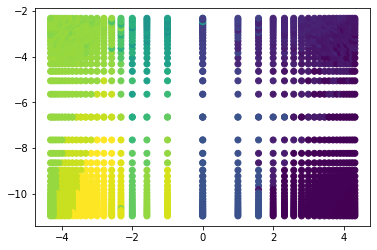

In [235]:
plt.scatter(np.log2(r[0]), np.log2(r[1]), c = r[3])

In [222]:
df

,gamma,risk,return,sharp
0,1.0,2.018157,13.342080,5.659659
1,1.0,1.691765,13.717868,6.973705
2,1.0,1.309045,13.710864,9.007228
3,1.0,1.309045,13.710864,9.007228
4,1.0,1.309045,13.710864,9.007228
...,...,...,...,...
795,20.0,1.103409,4.713041,2.531283
796,20.0,1.113677,5.025703,2.788692
797,20.0,1.182126,6.742124,4.079196
798,20.0,1.103409,4.713041,2.531283


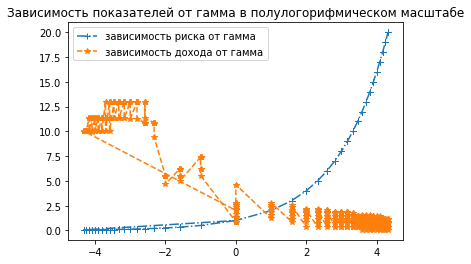

In [223]:
plt.title('Зависимость показателей от гамма в полулогорифмическом масштабе')
plt.plot(np.log2(np.array(r[0])),r[1],linestyle = '-.', marker = '+', label = 'зависимость риска от гамма')
plt.plot(np.log2(np.array(r[0])),r[2],linestyle = '--', marker = '*', label = 'зависимость дохода от гамма')
plt.legend()
plt.show()

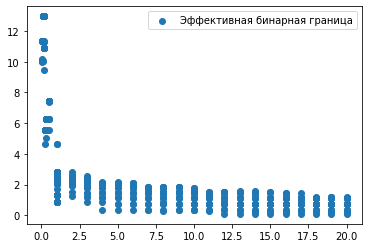

In [224]:
plt.scatter(r[1],r[2], label = 'Эффективная бинарная граница')
plt.legend()

plt.show()

In [ ]:
mask = np.array([1,0,0,1,1])
market_num = 2
B = 1

theta = [1,1,1e-3]

if weighted == False:
    A_list = np.array(([1] * portfolio.N))

# Sharp_weighted
elif weighted == True:
    A_list = (portfolio.market_profit/np.diagonal(portfolio.market_risk)).values


A_list = A_list/market_num
A_matrix = np.kron(np.reshape(A_list, [len(A_list),1]), A_list)

Cov = portfolio.market_risk.values
P = portfolio.market_profit.values


J_matrix = -1/4*(theta[1]*portfolio.market_risk.values + theta[2]*A_matrix)
h_list = -1/2*(theta[1]*np.sum(Cov, axis = 0) + theta[2]*np.sum(A_matrix, axis = 0) - theta[0]*P - 2*B*theta[2]*A_list)    
# h_list = -1/2*(theta[1]*np.diagonal(portfolio.market_risk.values) + theta[2]*np.diagonal(A_matrix) - theta[0]*P - 2*B*theta[2]*A_list)    
# g = theta[2]*B**2  
g =  - theta[0]/2*np.sum(P) + theta[1]/4*np.sum(Cov) + theta[2]/4*(np.sum(A_matrix) - 4*B*np.sum(A_list) + 4*B**2)

c1 = (-theta[0]*np.dot(mask, portfolio.market_profit.values) + 
theta[1]*np.dot(mask, np.dot(portfolio.market_risk.values ,mask)) + 
theta[2]*(np.dot(mask,A_list) - B)**2 )

c2 = -np.dot(2*mask - 1, h_list) - np.dot(2*mask-1, np.dot(J_matrix,2*mask-1)) + g

c1, c2

In [124]:
def exact_solution(portfolio, weighted = False, alpha = 0, fixed_param = 'risk', gamma_val = 0.1, rho_val = 1):
    portfolio.gamma = gamma_val
    portfolio.rho = rho_val
    best_mask = portfolio.mask
    
#     print(portfolio.gamma)
    
    if fixed_param == None:
        p = 0
        for i in range(1, 2**portfolio.N):
            m = list(map(int, list(bin(i)[2:])))
            mask = [0]*(portfolio.N - len(m)) + m
            portfolio.build_binary_portfolio(weighted = weighted, alpha = alpha, mask = mask)
            if portfolio.get_Sharp() > p:
                p  = portfolio.get_Sharp()
                weights = portfolio.get_weights()
                best_mask = mask
        
    elif fixed_param == 'risk':
        p = 100
        for i in range(1, 2**portfolio.N):
            m = list(map(int, list(bin(i)[2:])))
            mask = [0]*(portfolio.N - len(m)) + m
            portfolio.build_binary_portfolio(weighted = weighted, alpha = alpha, mask = mask)
            if portfolio.get_cost() < p:
                p  = portfolio.get_cost()
                weights = portfolio.get_weights()
                best_mask = mask
    portfolio.build_binary_portfolio(weighted = weighted, alpha = alpha, mask = best_mask)
        

In [163]:
# mask = [0]*22+[1]
portfolio.build_binary_portfolio(weighted = True, alpha = 0)

print(portfolio.cost, portfolio.Sharp_koef, portfolio.get_profit(period = 365)*100, portfolio.get_risk(period = 365)*100)  
_, time = get_time(exact_solution, {'portfolio' : portfolio, 'weighted' : False, 'alpha' : 0, 'gamma_val' : 6, 'rho_val' : 30})
print(portfolio.cost, portfolio.Sharp_koef, portfolio.get_profit(period = 365)*100, portfolio.get_risk(period = 365)*100)

-0.00010094092571200411 0.4619906991881011 3.898468014103605 4.282484512308472
--- 0.0040798187255859375 seconds ---
-0.00024399221932950525 3.6345360509102127 41.933229551011216 11.009171181832281


In [10]:
portfolio.build_portfolio()

In [11]:
portfolio.v_list

ARKK        0.001180
BNDX        0.000071
DERO-USD    0.000650
DGRO        0.000274
DOGE-USD    0.000278
ENJ-USD     0.001543
ESGU        0.000398
GOVT        0.000080
IEFA        0.000071
IEMG        0.000112
IUSB        0.000066
IXUS        0.000083
LINK-USD    0.004227
MTUM        0.000453
QUAL        0.000348
VLUE        0.000081
VTIP        0.000043
dtype: float64

In [368]:
data = portfolio.get_data()

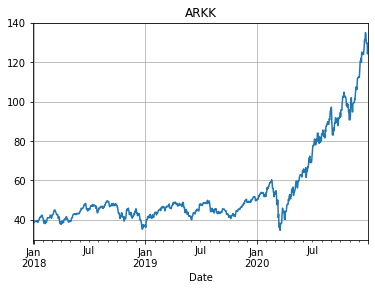

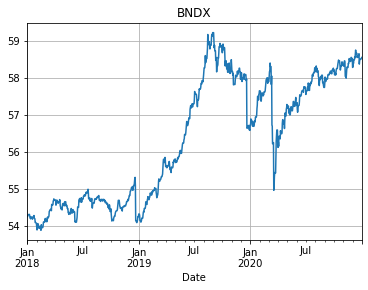

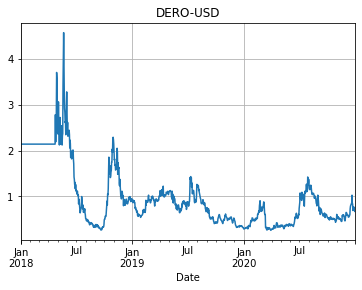

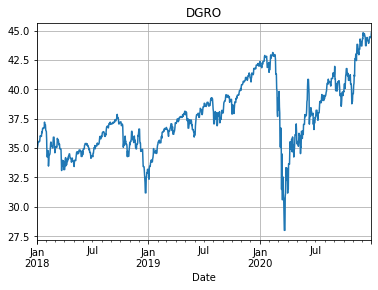

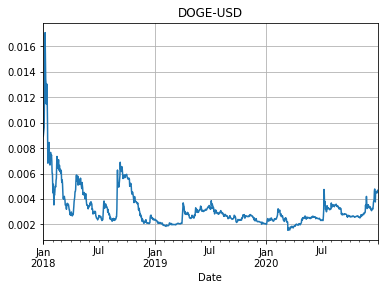

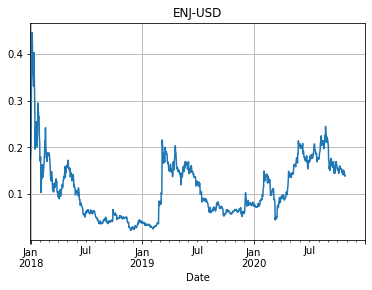

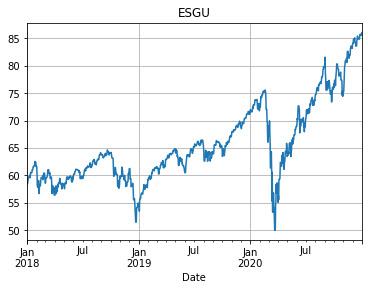

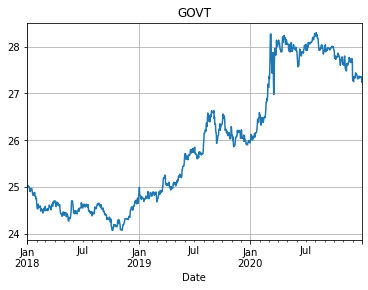

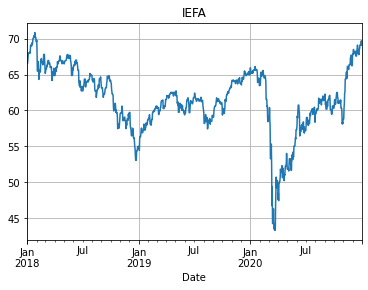

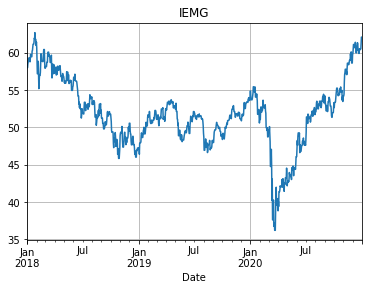

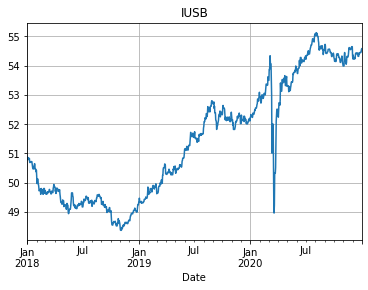

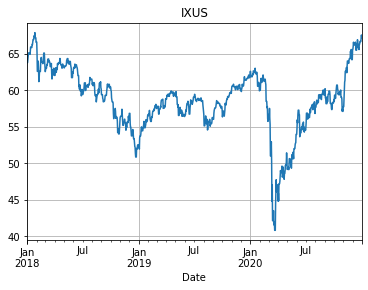

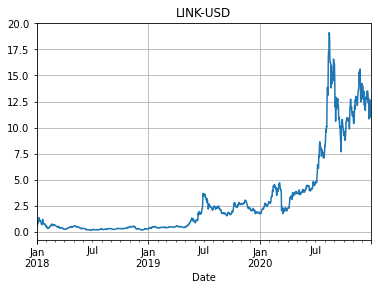

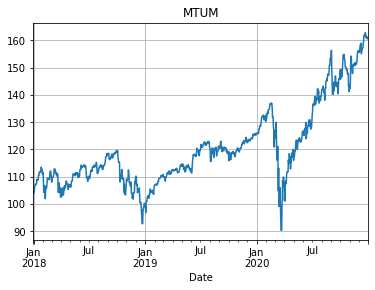

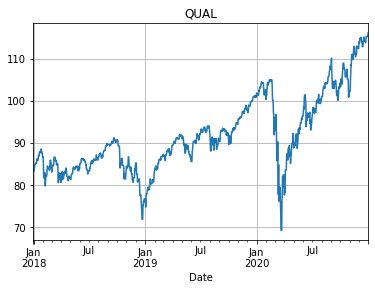

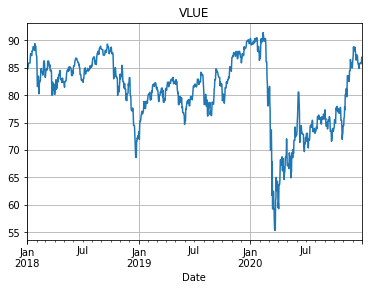

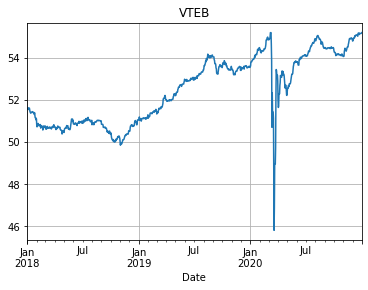

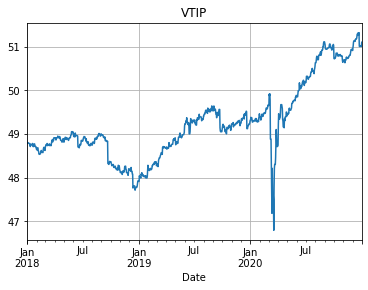

In [369]:
for name in data.Close.columns[:20]:
    data.Close[name].plot()
    plt.grid()
    plt.title(name)
    plt.show()

In [370]:
portfolio.get_market_risk()

,ARKK,BNDX,DERO-USD,DGRO,DOGE-USD,ENJ-USD,ESGU,GOVT,IEFA,IEMG,IUSB,IXUS,LINK-USD,MTUM,QUAL,VLUE,VTEB,VTIP
ARKK,0.000366,0.000005,0.000118,0.000163,1.537484e-04,0.000206,0.000183,-1.398692e-05,0.000150,0.000175,0.000004,0.000152,0.000274,0.000207,0.000175,0.000184,0.000017,9.335052e-06
BNDX,0.000005,0.000004,0.000016,0.000003,8.154141e-06,0.000014,0.000003,2.057327e-06,0.000003,0.000003,0.000003,0.000003,0.000015,0.000005,0.000002,0.000002,0.000004,1.294636e-06
DERO-USD,0.000118,0.000016,0.005797,0.000053,8.416022e-04,0.001311,0.000071,5.729983e-06,0.000048,0.000068,0.000019,0.000055,0.001128,0.000074,0.000058,0.000057,0.000020,1.279967e-05
DGRO,0.000163,0.000003,0.000053,0.000150,7.409409e-05,0.000146,0.000144,-1.499467e-05,0.000120,0.000126,0.000002,0.000118,0.000146,0.000140,0.000144,0.000163,0.000013,6.571703e-06
DOGE-USD,0.000154,0.000008,0.000842,0.000074,3.130102e-03,0.001869,0.000077,3.425183e-07,0.000074,0.000104,0.000010,0.000080,0.001730,0.000098,0.000080,0.000086,0.000017,1.278404e-05
ENJ-USD,0.000206,0.000014,0.001311,0.000146,1.869497e-03,0.007797,0.000131,4.178859e-06,0.000138,0.000165,0.000019,0.000142,0.002658,0.000151,0.000143,0.000161,0.000021,2.146815e-05
ESGU,0.000183,0.000003,0.000071,0.000144,7.694251e-05,0.000131,0.000150,-1.439371e-05,0.000118,0.000127,0.000002,0.000117,0.000152,0.000149,0.000144,0.000156,0.000013,6.708023e-06
GOVT,-0.000014,0.000002,0.000006,-0.000015,3.425183e-07,0.000004,-0.000014,6.278290e-06,-0.000011,-0.000012,0.000004,-0.000011,-0.000001,-0.000012,-0.000014,-0.000017,0.000003,7.161052e-07
IEFA,0.000150,0.000003,0.000048,0.000120,7.374242e-05,0.000138,0.000118,-1.147102e-05,0.000120,0.000124,0.000004,0.000117,0.000141,0.000115,0.000117,0.000133,0.000014,7.151414e-06
IEMG,0.000175,0.000003,0.000068,0.000126,1.037711e-04,0.000165,0.000127,-1.216376e-05,0.000124,0.000164,0.000003,0.000129,0.000142,0.000130,0.000126,0.000140,0.000016,7.633317e-06


In [371]:
print(portfolio.get_risk(), portfolio.get_profit(), portfolio.get_Sharp())
print(portfolio.get_weights())

0.0002531585281748179 0.0008791186379700493 3.2648155454335805
[0.10204864 0.07544025 0.12642177 0.16217669 0.06881852 0.01664706
 0.0255015  0.01700194 0.03300003 0.01069439 0.03277331 0.01632558
 0.04594704 0.07326099 0.12879357 0.00185664 0.03741379 0.02587828]


In [152]:
def get_effective_boundary(weighted = False):

    risk_list = []
    profit_list = []
    sharp_list = []
    # cost_list = []
    gamma_list = []

#     for i in reversed(range(1,21)):
#         exact_solution(portfolio, weighted = weighted, alpha = 0, gamma_val = 1/i, rho_val = 30)
#         risk_list.append(portfolio.get_risk(period = 365)*100)
#         profit_list.append(portfolio.get_profit(period = 365)*100)
#         gamma_list.append(1/i)
#         sharp_list.append(portfolio.get_Sharp())

    for i in range(1,41):
        exact_solution(portfolio, weighted = weighted, alpha = 0, gamma_val = i, rho_val = 30)
        risk_list.append(portfolio.get_risk(period = 365)*100)
        profit_list.append(portfolio.get_profit(period = 365)*100)
        gamma_list.append(i)
        sharp_list.append(portfolio.get_Sharp())
        
    return risk_list, profit_list, gamma_list, sharp_list


In [399]:
r, t = get_time(get_effective_boundary)

--- 908.6246809959412 seconds ---


In [413]:
df = pd.DataFrame(np.array(r).T, columns = ['risk','return','gamma','sharp'])
r = np.array(r)

In [421]:
df.head()

,risk,return,gamma,sharp
0,200.803682,194.432409,1.0,0.958710
1,58.532220,120.092670,2.0,2.018934
2,25.916406,81.048064,3.0,3.053204
3,14.687925,61.438201,4.0,4.052186
4,9.492594,49.642772,5.0,5.027369


In [424]:
df.to_excel('eff_bond.xlsx')

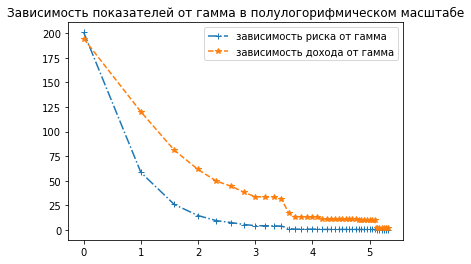

In [415]:
plt.title('Зависимость показателей от гамма в полулогорифмическом масштабе')
plt.plot(np.log2(np.array(r[2])),r[0],linestyle = '-.', marker = '+', label = 'зависимость риска от гамма')
plt.plot(np.log2(np.array(r[2])),r[1],linestyle = '--', marker = '*', label = 'зависимость дохода от гамма')
plt.legend()
plt.show()

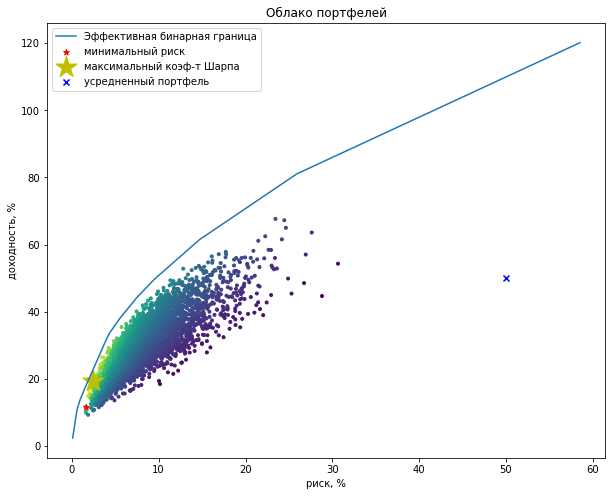

In [418]:
N = 4000

Sharp = np.zeros(N)
risk = np.zeros(N)
doh = np.zeros(N)
portf = np.zeros((N, portfolio.N))

for n in range(N):
    portfolio.build_portfolio()


    portf[n,:] = portfolio.get_weights()
    risk[n] = portfolio.get_risk(period = 365)
    doh[n] = portfolio.get_profit(period = 365)
    Sharp[n] = portfolio.get_Sharp()
    

    
    
old_risk = risk.copy()

risk = risk[(old_risk<1)&(doh<1)]
doh = doh[(old_risk<1)&(doh<1)]

del old_risk

plt.figure(figsize=(10,8))

plt.scatter(risk*100,doh*100,c=list((doh-R0)/risk),marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей")



min_risk = np.argmin(risk)
plt.scatter([(risk[min_risk])*100],[(doh[min_risk])*100],c='r',marker='*',label='минимальный риск')

maxSharpKoef = np.argmax((doh-R0)/risk)
plt.scatter([risk[maxSharpKoef]*100],[doh[maxSharpKoef]*100],c='y',s = 500,marker='*',label='максимальный коэф-т Шарпа')

r_mean = np.ones(portfolio.N)/portfolio.N
portfolio.build_binary_portfolio(weighted=True, mask = list(r_mean))
risk_mean = portfolio.get_risk(period=365)
doh_mean = portfolio.get_profit(period=365)
plt.scatter([min(0.5, risk_mean)*100],[min(0.5, doh_mean)*100],c='b',marker='x',label='усредненный портфель')
plt.plot(r[0][r[0]<100],r[1][r[0]<100], label = 'Эффективная бинарная граница')
plt.legend()

plt.show()

/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


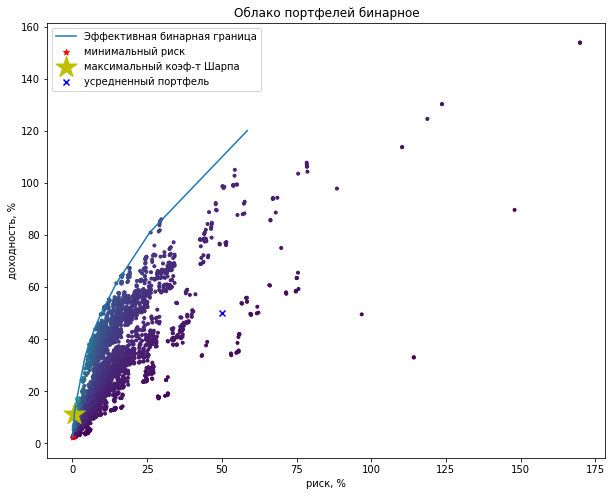

In [425]:
N = 4000

Sharp_bin = np.zeros(N)
risk = np.zeros(N)
doh = np.zeros(N)
portf = np.zeros((N, portfolio.N))

for n in range(N):
    portfolio.build_binary_portfolio(weighted = True, alpha = 0.5)


    portf[n,:] = portfolio.get_weights()
    risk[n] = portfolio.get_risk(period = 365)
    doh[n] = portfolio.get_profit(period = 365)
    Sharp_bin[n] = portfolio.get_Sharp()
    
    
old_risk = risk.copy()

risk = risk[(old_risk<2)&(doh<2)]
doh = doh[(old_risk<2)&(doh<2)]

del old_risk

plt.figure(figsize=(10,8))

plt.scatter(risk*100,doh*100,c=list((doh-R0)/risk),marker='.')
plt.xlabel('риск, %')
plt.ylabel('доходность, %')
plt.title("Облако портфелей бинарное")

min_risk = np.argmin(risk[~np.isnan(risk)])
plt.scatter([(risk[min_risk])*100],[(doh[min_risk])*100],c='r',marker='*',label='минимальный риск')

maxSharpKoefb = np.argmax(((doh-R0)/risk)[~np.isnan(risk)])
plt.scatter([risk[maxSharpKoefb]*100],[doh[maxSharpKoefb]*100],c='y',s = 500,marker='*',label='максимальный коэф-т Шарпа')

r_mean = np.ones(portfolio.N)/portfolio.N
portfolio.build_binary_portfolio(weighted=True, mask = list(r_mean))
risk_mean = portfolio.get_risk(period=365)
doh_mean = portfolio.get_profit(period=365)
plt.scatter([min(0.5, risk_mean)*100],[min(0.5, doh_mean)*100],c='b',marker='x',label='усредненный портфель')
plt.plot(r[0][r[0]<100],r[1][r[0]<100], label = 'Эффективная бинарная граница')
plt.legend()

plt.show()

In [420]:
portfolio.N

18

In [411]:
import pandas as pd

print('---------- Минимальный риск ----------')
print()
print("Шарп = %.2f" % float(Sharp_bin[min_risk]))
print("риск = %1.2f%%" % (float(risk[min_risk])*100.0))
print("доходность = %1.2f%%" % (float(doh[min_risk])*100.0)) 
print()
print(pd.DataFrame([portf[min_risk]*100],columns=portfolio.get_change_data().columns,index=['доли, %']).T)
print()

print('---------- Максимальный коэффициент Шарпа ----------')
print()
print("Шарп = %1.2f" % (float(Sharp[maxSharpKoef])))
print("риск = %1.2f%%" % (float(risk[maxSharpKoef])*100.0))
print("доходность = %1.2f%%" % (float(doh[maxSharpKoef])*100.0)) 
print()
print(pd.DataFrame([portf[maxSharpKoef]*100],columns=portfolio.get_change_data().columns,index=['доли, %']).T)
print()

print('---------- Максимальный коэффициент Шарпа бинарный ----------')
print()
print("Шарп = %1.2f" % (float(Sharp_bin[maxSharpKoefb])))
print("риск = %1.2f%%" % (float(risk[maxSharpKoefb])*100.0))
print("доходность = %1.2f%%" % (float(doh[maxSharpKoefb])*100.0)) 
print()
print(pd.DataFrame([portf[maxSharpKoefb]*100],columns=portfolio.get_change_data().columns,index=['доли, %']).T)
print()

print('---------- Средний портфель ----------')
print()
print("Шарп = %1.2f" % (float(np.mean(Sharp_bin))))
print("риск = %1.2f%%" % (float(risk_mean)*100.0)) 
print("доходность = %1.2f%%" % (float(doh_mean)*100.0)) 
print()
print(pd.DataFrame([r_mean*100],columns=portfolio.get_change_data().columns,index=['доли, %']).T)
print()

---------- Минимальный риск ----------

Шарп = 4.39
риск = 1.52%
доходность = 9.13%

            доли, %
ARKK       1.026581
BNDX       4.847827
DERO-USD   2.507594
DGRO       5.508140
DOGE-USD   0.206359
ENJ-USD    1.093301
ESGU       3.986765
GOVT       6.473941
IEFA       6.792962
IEMG      13.056333
IUSB      20.286914
IXUS       1.758678
LINK-USD   0.211687
MTUM       3.781530
QUAL       7.994784
VLUE       2.589029
VTEB       7.261959
VTIP      10.615617

---------- Максимальный коэффициент Шарпа ----------

Шарп = 8.13
риск = 1.89%
доходность = 17.28%

            доли, %
ARKK       1.818977
BNDX      12.610150
DERO-USD   2.910872
DGRO       9.418502
DOGE-USD   0.221542
ENJ-USD    3.383655
ESGU       0.152659
GOVT      16.369014
IEFA       2.140070
IEMG       1.569592
IUSB      12.082164
IXUS       2.734715
LINK-USD   3.243086
MTUM       5.113974
QUAL       3.671262
VLUE       1.155531
VTEB       6.802954
VTIP      14.601284

---------- Максимальный коэффициент Шарпа бинарный --

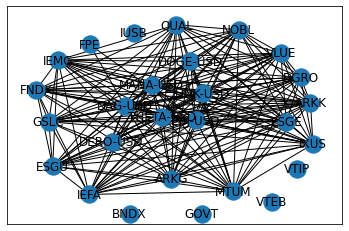

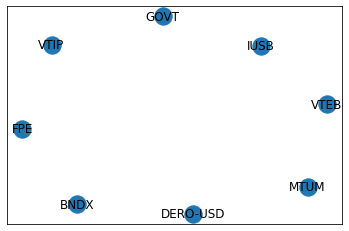

[1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 1]


In [453]:
portfolio.build_market_graph(edge = 0.03)
portfolio.build_mwis()
portfolio.draw_market()
plt.show()
portfolio.draw_wmis()
plt.show()
print(portfolio.wmis_mask)

In [484]:
for i in range(100):
    portfolio.build_market_graph(edge = i/100)
    portfolio.build_mwis()

    print('NONweighted')
    print(i/100)
    print('_____________')
    portfolio.build_binary_portfolio(weighted = False,alpha = 0 , mask = list(portfolio.wmis_mask))
    print('Return: {0} %'.format( portfolio.get_profit(period = 365)*100))
    print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
    print('Sharp: {0}'.format(portfolio.get_Sharp()))
    print('_____________')
    print()

NONweighted
0.0
_____________
Return: 93.45392263053735 %
Risk: 164.59237166417097 %
Sharp: 0.5561249388720169
_____________

NONweighted
0.01
_____________
Return: 24.972715043766165 %
Risk: 11.251592741802522 %
Sharp: 2.0488401573689634
_____________

NONweighted
0.02
_____________
Return: 24.972715043766165 %
Risk: 11.251592741802522 %
Sharp: 2.0488401573689634
_____________

NONweighted
0.03
_____________
Return: 27.92684040286315 %
Risk: 8.613907929907722 %
Sharp: 3.019168606686252
_____________

NONweighted
0.04
_____________
Return: 32.890396172594386 %
Risk: 16.870314006054095 %
Sharp: 1.8357925146787617
_____________

NONweighted
0.05
_____________
Return: 29.438134228495855 %
Risk: 14.030231336626311 %
Sharp: 1.961345723263949
_____________

NONweighted
0.06
_____________
Return: 30.73972625154182 %
Risk: 8.075572547845312 %
Sharp: 3.5687533089194243
_____________

NONweighted
0.07
_____________
Return: 33.540261732679475 %
Risk: 9.496375909083573 %
Sharp: 3.329718835417386
_

NONweighted
0.66
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.67
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.68
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.69
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.7
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.71
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.72
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
_____________

NONweighted
0.73
_____________
Return: 29.33994638473566 %
Risk: 7.083899117141377 %
Sharp: 3.8707420773943277
________

In [483]:
print('weighted random')
portfolio.build_binary_portfolio(weighted = True,alpha = 0.5, mask = None)
print('Return: {0} %'.format(portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

weighted random
Return: 59.1278857841527 %
Risk: 30.32358585017065 %
Sharp: 1.8865805009611272
_____________



In [429]:
print('weighted')
portfolio.build_binary_portfolio(weighted = True,alpha = 10e-5, mask = list(portfolio.wmis_mask))
print('Return: {0} %'.format(portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

print('NONweighted')
portfolio.build_binary_portfolio(weighted = False,alpha = 0 , mask = list(portfolio.wmis_mask))
print('Return: {0} %'.format( portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

print('weighted random')
portfolio.build_binary_portfolio(weighted = True,alpha = 0.5, mask = None)
print('Return: {0} %'.format(portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

print('exact weighted solution')
exact_solution(portfolio, weighted = True, alpha = 10e-5, fixed_param = None)
print('Return: {0} %'.format(portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

print('exact NONweighted solution')
exact_solution(portfolio, weighted = False, alpha = 0, fixed_param = None)
print('Return: {0} %'.format(portfolio.get_profit(period = 365)*100))
print('Risk: {0} %'.format(portfolio.get_risk(period = 365)*100))
print('Sharp: {0}'.format(portfolio.get_Sharp()))
print('_____________')
print()

weighted
Return: 31.070331142837777 %
Risk: 11.471409349518225 %
Sharp: 2.5411290151599397
_____________

NONweighted
Return: 28.448815742524047 %
Risk: 9.28555471876674 %
Sharp: 2.8569984826978083
_____________

weighted random
Return: 54.24634520598124 %
Risk: 24.00126738440897 %
Sharp: 2.180149254950262
_____________

exact weighted solution
Return: 9.68404630734027 %
Risk: 0.5147674096751421 %
Sharp: 15.082629866253537
_____________

exact NONweighted solution
Return: 9.65651852255073 %
Risk: 0.5119440482376127 %
Sharp: 15.11203919487685
_____________



# Расчёт оптимального портфолио на D-wave:

In [230]:
import neal
import dimod

In [248]:
def std_effective_boundary(portfolio, sampler, weighted = False, theta = [1, 3, 0.01]):

    risk_list = []
    profit_list = []
    sharp_list = []
    gamma_list = []
    
    portfolio.B = 1


    for i in range(1,41):

        
        theta[0] = i
        theta[1] = 1
        theta[2] = 1

        portfolio.build_Ising_hamiltonian(theta, weighted = weighted)
#         print(portfolio.J, portfolio.h)
        sampleset = sampler.sample_ising(portfolio.h, portfolio.J)
        mask = np.array(list(sampleset.first.sample.values()))

#         mask[mask == 1] = 0
        mask[mask == -1] = 0
        print(mask)


        portfolio.build_binary_portfolio(weighted = False, alpha = 0 , mask = list(mask))

        print(portfolio.get_Sharp())

        risk_list.append(portfolio.get_risk(period = 365)*100)
        profit_list.append(portfolio.get_profit(period = 365)*100)
        gamma_list.append(i)
        sharp_list.append(portfolio.get_Sharp())

    return risk_list, profit_list, gamma_list, sharp_list

In [249]:
sampler =  neal.SimulatedAnnealingSampler() # dimod.ExactSolver() #
weighted = False
theta_init = [1,1,1]

r, t = get_time(std_effective_boundary, {'portfolio': portfolio, 'sampler': sampler, 'weighted': weighted, 'theta': theta_init})

df = pd.DataFrame(np.array(r).T, columns = ['risk','return','gamma','sharp'])
r = np.array(r)



[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
[0 0 0 0 0]
nan
--- 0.20137977600097656 seconds ---


/home/stas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:236: RuntimeWarning: invalid value encountered in true_divide


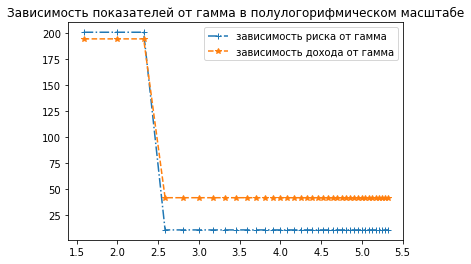

In [241]:
plt.title('Зависимость показателей от гамма в полулогорифмическом масштабе')
plt.plot(np.log2(np.array(r[2])),r[0],linestyle = '-.', marker = '+', label = 'зависимость риска от гамма')
plt.plot(np.log2(np.array(r[2])),r[1],linestyle = '--', marker = '*', label = 'зависимость дохода от гамма')
plt.legend()
plt.show()

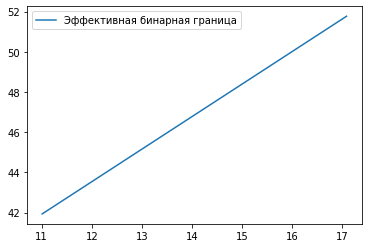

In [184]:
plt.plot(r[0],r[1], label = 'Эффективная бинарная граница')
plt.legend()

plt.show()

In [132]:
B = 1
theta = [1,2,0.01]

portfolio.build_Ising_hamiltonian(theta, weighted = False)
portfolio.J, portfolio.h

({(0, 0): -0.00019150536971631967,
  (0, 1): -1.1323982038171461e-05,
  (0, 2): -6.780483677878385e-05,
  (0, 3): -9.00294624678473e-05,
  (0, 4): -8.552473196151136e-05,
  (0, 5): -0.00011140986460799069,
  (0, 6): -0.00010038894799821582,
  (0, 7): -1.6570579421971248e-06,
  (0, 8): -8.37227906373771e-05,
  (0, 9): -9.597853488847113e-05,
  (0, 10): -1.0881832339887327e-05,
  (0, 11): -8.48827936514346e-05,
  (0, 12): -0.00014547787426826112,
  (0, 13): -0.00011219575419750499,
  (0, 14): -9.632538552723582e-05,
  (0, 15): -0.0001006121875404498,
  (0, 16): -1.3318044830141232e-05,
  (1, 0): -1.1323982038171461e-05,
  (1, 1): -1.0511534582137727e-05,
  (1, 2): -1.6651777478016544e-05,
  (1, 3): -9.998550689205624e-06,
  (1, 4): -1.272758961909921e-05,
  (1, 5): -1.5508107595154548e-05,
  (1, 6): -1.0185125907581246e-05,
  (1, 7): -9.679182491165085e-06,
  (1, 8): -1.0187451867683224e-05,
  (1, 9): -1.0395048133909998e-05,
  (1, 10): -1.0060784005203637e-05,
  (1, 11): -1.001032975418

In [80]:
import neal
import dimod

sampler = neal.SimulatedAnnealingSampler()
dimod.ExactSolver()

# h = {0: -1, 1: -1}
# J = {(0, 1): -1}
sampleset = sampler.sample_ising(h, J)
sampleset

SampleSet(rec.array([([-1, -1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1], -0.04476037, 1)],
          dtype=[('sample', 'i1', (17,)), ('energy', '<f8'), ('num_occurrences', '<i8')]), Variables(range(0, 17)), {'beta_range': [52.38161745009741, 33266193.343708985], 'beta_schedule_type': 'geometric'}, 'SPIN')

In [81]:
sampleset.first.sample

{0: -1,
 1: -1,
 2: 1,
 3: -1,
 4: 1,
 5: 1,
 6: -1,
 7: -1,
 8: -1,
 9: -1,
 10: -1,
 11: -1,
 12: 1,
 13: -1,
 14: -1,
 15: -1,
 16: -1}

In [82]:
sampleset = dimod.ExactSolver().sample_ising(h, J)
sampleset = sampler.sample_ising(h, J)
sampleset

In [83]:
sampleset = sampler.sample_ising(h, J)
sampleset
sampleset.first.sample


{0: -1,
 1: -1,
 2: 1,
 3: -1,
 4: 1,
 5: 1,
 6: -1,
 7: -1,
 8: -1,
 9: -1,
 10: -1,
 11: -1,
 12: 1,
 13: -1,
 14: -1,
 15: -1,
 16: -1}

In [107]:
list(sampleset.first.sample.values())

[-1, -1, 1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1]

# Построим графы связей

In [238]:
import networkx as nx
import math

from itertools import combinations
from operator import itemgetter
from timeit import default_timer
from random import shuffle

EPS = 1e-6

{'ARKG': 0.03380781810155805, 'BNDX': 0.03485110923359619, 'DGRO': 0.1389663796343437, 'DGRW': 0.025501811090265433, 'ESGD': 0.02705208092357454, 'ESGE': 0.01901240629702871, 'ESGU': 0.01968758912369472, 'FNDF': 0.03096539567508984, 'FNDX': 0.013442828567233375, 'FPE': 0.022542725257099806, 'FTEC': 0.0164629905849021, 'GOVT': 0.034864496994029354, 'GSLC': 0.0974220488857611, 'HYLB': 0.030039250096222235, 'IEFA': 0.01383564802909919, 'IEMG': 0.017385057460931396, 'INDA': 0.01799174878000264, 'IUSB': 0.018135640675588982, 'IXUS': 0.08215802138155345, 'LMBS': 0.01818230712974155, 'MOAT': 0.0, 'MTUM': 0.03056898159398528, 'NOBL': 0.030755878329998886, 'PDBC': 0.024983994372454032, 'QUAL': 0.004793382918159588, 'SRLN': 0.029316202602280607, 'VLUE': 0.007689658315291212, 'VTEB': 0.016315132736356455, 'VTIP': 0.03938061501505985, 'ARKK': 0.1038888001950977} 30


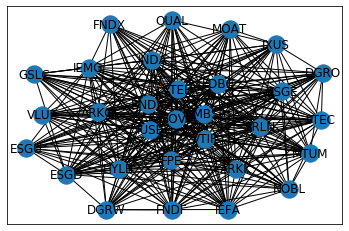

In [134]:
# dCloseData.cov().to_dict().keys()
def build_graph(portfolio, edge = 0.25):
    
    dCloseData = portfolio.get_change_data()
    clist = []
    elist = []
    v_list = []
    for c1, p  in zip(dCloseData.corr().to_dict().keys(), portfolio.v_list):
        clist.append(c1)
        v_list.append(p)
        for c2, corr in dCloseData.corr().to_dict()[c1].items():
#             print(c1, c2, corr, edge)
            if ((clist.count(c2)==0) & (corr < edge) & (c1 != c2)):
                elist.append((c1, c2, 1-corr))
#     print(vlist)
                
    G=nx.Graph()
    G.add_weighted_edges_from(elist)
    pi = dict(zip(G.nodes(), v_list))


    return elist, G, pi

vlist, G, pi = build_graph(portfolio, edge = 0.90)
print(pi, len(pi.values()))
nx.draw_networkx(G)

In [135]:
# G.graph

In [137]:
start_time = default_timer()
mwis_set, mwis_weight = exact_MWIS(G, pi, 0)
elapsed = default_timer() - start_time
print('exact set', mwis_set, mwis_weight)
print(len(mwis_set))

exact set ('DGRO', 'DGRW', 'ESGU', 'FNDX', 'GSLC', 'MOAT', 'NOBL', 'QUAL', 'VLUE') 0.33825957686474806
9


In [146]:
mask = []
for t in set(sample_ticker):
    mask.append(int(t in mwis_set))
mask = np.array(mask)
mask

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0])

In [88]:

# G.add_edge(1,2)  # значение по умолчанию для дуги задаётся = 1
# G.add_edge(2,3,weight=0.9) # задаётся значение атрибута
# G.add_edge('y','x',function=np.cos)
# G.add_node(np.cos) #

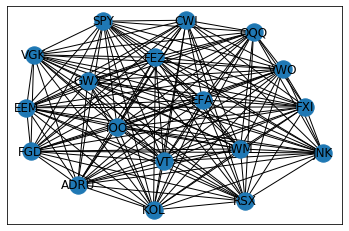

In [89]:
#nx.draw(G)   # тип по умолчанию spring_layout
nx.draw_networkx(G)
# nx.draw(G,pos=nx.spectral_layout(G), nodecolor='r',edge_color='b')

# Оптимизация портфеля:

In [95]:
portfolio.build_rand_portfolio()

x_init = portfolio.get_weights()
R_init = portfolio.get_market_profit()
V_init = portfolio.get_market_risk()


In [96]:
R_init, V_init, x_init

(ADRU    0.000019
 CWI     0.000087
 EEM     0.000066
 EFA     0.000095
 EMJ    -0.000039
 FEZ     0.000023
 FGD     0.000055
 FXI     0.000083
 GDX    -0.000072
 GWX     0.000103
 IOO     0.000204
 IWM     0.000413
 JNK    -0.000052
 KOL    -0.000312
 QQQ     0.000597
 RSX    -0.000022
 SPY     0.000401
 VGK     0.000093
 VT      0.000238
 VWO     0.000056
 dtype: float64,
           ADRU       CWI       EEM       EFA       EMJ       FEZ       FGD  \
 ADRU  0.000139  0.000116  0.000119  0.000118  0.000009  0.000158  0.000103   
 CWI   0.000116  0.000130  0.000141  0.000129  0.000010  0.000163  0.000113   
 EEM   0.000119  0.000141  0.000186  0.000137  0.000013  0.000166  0.000122   
 EFA   0.000118  0.000129  0.000137  0.000135  0.000009  0.000169  0.000115   
 EMJ   0.000009  0.000010  0.000013  0.000009  0.000081  0.000011  0.000010   
 FEZ   0.000158  0.000163  0.000166  0.000169  0.000011  0.000240  0.000147   
 FGD   0.000103  0.000113  0.000122  0.000115  0.000010  0.000147  0.0

In [102]:
def calc_loss(vec, risk_matrix, profit_vec):
    profit = np.dot(vec,profit_vec)
    risk = np.dot(vec, np.dot(risk_matrix,vec))
    Sharp = profit/risk
    return - Sharp


loss = calc_loss(x_init, V_init, R_init)    
loss

-0.5951249068544566

In [93]:
v_list, e_matrix = po
